### **Part 1: Setup and Simulation**
This first part of the notebook handles all the necessary setup, configuration, and the main computationally intensive simulation. The goal is to run the biophysical calculations once and store all the detailed results in memory for the analysis sections that follow.


#### **Step 1: Imports**
This cell imports all the necessary Python libraries for the analysis, including `pandas` for data handling, `matplotlib` and `seaborn` for plotting, and the `ViennaRNA` package for the core thermodynamic calculations.

In [18]:
# Cell 1: Imports
import os
import urllib.request
import gzip
import shutil
import glob
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyfaidx
import traceback
import math
import random
import warnings
from IPython.display import display, HTML

# ViennaRNA Python bindings
import RNA

# Parallel / stats
from multiprocess import Pool, cpu_count
from tqdm.notebook import tqdm
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

warnings.filterwarnings("ignore", category=UserWarning)

#### **Step 2: Configuration**
This is the main control panel for the entire analysis. Here you can specify the input FASTA file, point to your experimental conditions CSV, and define the fallback proxy conditions.

In [19]:
# Cell 2: Configuration for Per-Probe Conditions

# --- INPUT FILE ---
INPUT_FASTA_FILE = "example_genomes/phix174_genome/phix174.fna"

# --- NEW: CONDITIONS DATABASE ---
# Path to your experimental conditions file
PROBE_CONDITIONS_CSV = "probe_conditions.csv"

# Proxy conditions for any 5-mer NOT in the CSV, based on its GC content.
# This dictionary is now the single source of truth for your proxy model.
PROXY_CONDITIONS = {
    # gc_percent: (base_temp_c, formamide_percent)
    0:   (32.0, 0.0),
    20:  (32.0, 25.0),
    40:  (32.0, 35.0),
    60:  (39.0, 35.0),
    80:  (39.0, 55.0),
    100: (39.0, 70.0),
}

# --- EXPLICIT MODEL SELECTION ---
MODEL_LOADER = RNA.params_load_RNA_Turner2004
MODEL_TYPE = 'RNA'

# --- I/O and Processing Parameters ---
base_name = os.path.splitext(INPUT_FASTA_FILE)[0]
RESULTS_FILE_PREFIX = f"{base_name}_per_probe_results"
ENVIRONMENT_FILE = "environment.yml"
NUM_CORES = cpu_count()

# --- Core Model Parameters ---
PROBE_LENGTH    = 5
FRAGMENT_LENGTH = 170

# --- GLOBAL Experimental Conditions (NO LONGER USED IN SIMULATION) ---
# These are now superseded by the per-probe conditions, but we keep them for context.
BASE_TEMPERATURE_C = 39.0
FORMAMIDE_PERCENT  = 70.0
EFFECTIVE_TEMPERATURE_C = BASE_TEMPERATURE_C + (FORMAMIDE_PERCENT / 10.0 * 7.0)
EQUIVALENT_SALT_mM = 150.0

# --- Accessibility Heuristics ---
P_OPEN_THRESHOLD    = 0.50
CONSENSUS_THRESHOLD = 0.50

# --- Set Global ViennaRNA Defaults (Salt is still global) ---
if hasattr(RNA.cvar, "salt"):
    RNA.cvar.salt = float(EQUIVALENT_SALT_mM) / 1000.0

# --- Setup ---
random.seed(42); np.random.seed(42); sns.set_theme(style="whitegrid", palette="viridis")

print("--- Per-Probe Condition Exhaustive Genome Pipeline ---")
print(f"Analyzing Genome: {INPUT_FASTA_FILE}")
print(f"Using experimental conditions from: {PROBE_CONDITIONS_CSV}")
print(f"Model Selected: {MODEL_LOADER.__name__} ({MODEL_TYPE})")
print("-----------------------------------------------------")

--- Per-Probe Condition Exhaustive Genome Pipeline ---
Analyzing Genome: example_genomes/phix174_genome/phix174.fna
Using experimental conditions from: probe_conditions.csv
Model Selected: params_load_RNA_Turner2004 (RNA)
-----------------------------------------------------


#### **Step 3: Core Function Definitions**
This cell contains the scientific engine of the pipeline. It includes the new logic to create a "conditions lookup" function from your CSV and proxy rules. The main worker function, `process_locus_accessibility`, has been significantly updated to fold each fragment multiple times based on the specific conditions required by the 5-mer sites within it.

In [20]:
# Cell 3: Core Function Definitions (Per-Probe Logic)

def reverse_complement(dna_sequence: str) -> str:
    """Computes the reverse complement of a DNA sequence."""
    complement_map = str.maketrans("ATGC", "TACG")
    return dna_sequence.upper().translate(complement_map)[::-1]

def calculate_gc_content(sequence: str) -> float:
    if not sequence: return 0.0
    s = sequence.upper()
    return 100.0 * (s.count('G') + s.count('C')) / len(s)

def calculate_effective_temp(base_temp, formamide_pct):
    """Calculates the effective temperature for ViennaRNA."""
    return base_temp + (formamide_pct / 10.0 * 7.0)

def create_condition_lookup(conditions_csv_path, proxy_rules):
    """
    Creates a single function that can look up the conditions for any 5-mer.
    It prioritizes the experimental CSV and falls back to the proxy rules.
    """
    # 1. Load experimental data
    try:
        df = pd.read_csv(conditions_csv_path)
        # Handle duplicates by taking the most stringent (max temp, then max formamide)
        df['effective_temp'] = df.apply(lambda row: calculate_effective_temp(row.base_temp_c, row.formamide_percent), axis=1)
        df = df.sort_values('effective_temp', ascending=False).drop_duplicates('sequence', keep='first')
        
        experimental_conditions = {
            row.sequence: row.effective_temp for _, row in df.iterrows()
        }
        print(f"Successfully loaded {len(experimental_conditions)} unique, experimentally optimized probes.")
    except FileNotFoundError:
        print(f"Warning: {conditions_csv_path} not found. Using only proxy rules.")
        experimental_conditions = {}

    # 2. Prepare proxy data
    proxy_temps = {
        gc: calculate_effective_temp(temp, form)
        for gc, (temp, form) in proxy_rules.items()
    }

    def get_effective_temp(sequence: str) -> float:
        """The final lookup function."""
        if sequence in experimental_conditions:
            return experimental_conditions[sequence]
        
        gc_val = calculate_gc_content(sequence)
        closest_gc_bin = round(gc_val / 20) * 20
        return proxy_temps.get(closest_gc_bin, 60.0)

    return get_effective_temp

def get_up_matrix(sequence: str, ulength: int, model_type: str) -> np.ndarray:
    seq_for_calc = sequence.replace('T', 'U') if model_type == 'RNA' else sequence
    N = len(seq_for_calc)
    M = np.zeros((N + 1, ulength + 1), dtype=float)
    mat = RNA.pfl_fold_up(seq_for_calc, ulength, N, N)
    if mat is None: return M
    for i in range(1, N + 1):
        if i < len(mat):
            row = mat[i]
            for L in range(1, ulength + 1):
                if L < len(row):
                    M[i, L] = row[L]
    return M

def analyze_fragment_accessibility_from_up(sequence: str, p_open_array: np.ndarray) -> dict:
    valid = len(sequence) - PROBE_LENGTH + 1
    if valid < 1: return {"frac_open_sites": 0.0, "is_accessible": False, "open_sites_count": 0}
    open_sites_count = int(np.sum(p_open_array >= P_OPEN_THRESHOLD))
    frac_open_sites = open_sites_count / valid
    is_accessible = frac_open_sites >= CONSENSUS_THRESHOLD
    return {"frac_open_sites": frac_open_sites, "is_accessible": is_accessible, "open_sites_count": open_sites_count}

def process_locus_accessibility(args):
    """
    NEW WORKER: Analyzes a locus by folding the fragment multiple times,
    once for each unique temperature required by the sites within it.
    """
    locus_details, model_type, condition_lookup_func = args
    fwd_seq, rc_seq = locus_details['fwd_seq'], locus_details['rc_seq']
    
    p_open_fwd = np.zeros(len(fwd_seq) - PROBE_LENGTH + 1)
    p_open_rc = np.zeros(len(rc_seq) - PROBE_LENGTH + 1)
    pu1_fwd, pu1_rc = np.zeros(len(fwd_seq)), np.zeros(len(rc_seq))
    
    for strand_seq, p_open_array, pu1_array in [(fwd_seq, p_open_fwd, pu1_fwd), (rc_seq, p_open_rc, pu1_rc)]:
        jobs = {}
        for i in range(len(strand_seq) - PROBE_LENGTH + 1):
            site_motif = strand_seq[i : i + PROBE_LENGTH]
            temp = condition_lookup_func(site_motif)
            jobs.setdefault(temp, []).append(i)
        
        for temp, site_indices in jobs.items():
            RNA.cvar.temperature = temp
            up_matrix = get_up_matrix(strand_seq, PROBE_LENGTH, model_type)
            for i in site_indices:
                p_open_array[i] = up_matrix[i + 1, PROBE_LENGTH]
            if not np.any(pu1_array):
                for i in range(len(strand_seq)):
                    pu1_array[i] = up_matrix[i + 1, 1]

    metrics_fwd = analyze_fragment_accessibility_from_up(fwd_seq, p_open_fwd)
    metrics_rc = analyze_fragment_accessibility_from_up(rc_seq, p_open_rc)
    
    return {
        "start_pos": locus_details['start_pos'], "fwd_seq": fwd_seq, "rc_seq": rc_seq,
        "gc_content": locus_details['gc_content'], "gc_bin": locus_details['gc_bin'],
        "frac_open_sites_fwd": metrics_fwd['frac_open_sites'], "frac_open_sites_rc": metrics_rc['frac_open_sites'],
        "open_sites_fwd": metrics_fwd['open_sites_count'], "open_sites_rc": metrics_rc['open_sites_count'],
        "p_open_fwd": p_open_fwd, "p_open_rc": p_open_rc,
        "pu1_fwd": pu1_fwd, "pu1_rc": pu1_rc,
        "frac_open_sites": max(metrics_fwd['frac_open_sites'], metrics_rc['frac_open_sites']),
        "is_accessible": metrics_fwd['is_accessible'] or metrics_rc['is_accessible'],
    }

def _wilson_ci(k, n, z=1.96):
    if n == 0: return (0.0, 0.0, 0.0)
    p = k / n
    denom = 1 + z**2 / n
    center = (p + z**2/(2*n)) / denom
    half = z * np.sqrt(p*(1-p)/n + z**2/(4*n**2)) / denom
    return (p, max(0.0, center - half), min(1.0, center + half))

print("All core functions defined successfully.")

All core functions defined successfully.


#### **Step 4: Run Main Simulation**
This is the main computationally intensive step. It prepares all genomic fragments, creates the conditions lookup function, and then runs the complex per-probe condition simulation in parallel.

In [21]:
# Cell 4: Main Simulation (Per-Probe Conditions)

if not os.path.exists(INPUT_FASTA_FILE):
    print(f"ERROR: Input file not found at '{INPUT_FASTA_FILE}'")
else:
    # --- 1. Create the master condition lookup function ---
    condition_lookup = create_condition_lookup(PROBE_CONDITIONS_CSV, PROXY_CONDITIONS)
    
    print(f"\n--- [1/2] Preparing Loci from {INPUT_FASTA_FILE} ---")
    MODEL_LOADER()
    print(f"Successfully loaded model: {MODEL_LOADER.__name__}")

    fasta = pyfaidx.Fasta(INPUT_FASTA_FILE)
    loci_to_process = []
    gc_bins = [0, 35, 45, 55, 65, 101]
    gc_bin_labels = ["0-35%", "35-45%", "45-55%", "55-65%", "65-100%"]

    for contig_key in fasta.keys():
        sequence = fasta[contig_key][:].seq.upper()
        for i in range(0, len(sequence) - FRAGMENT_LENGTH + 1, FRAGMENT_LENGTH):
            fwd_seq = sequence[i : i + FRAGMENT_LENGTH]
            if 'N' in fwd_seq: continue
            
            gc = calculate_gc_content(fwd_seq)
            gc_bin = pd.cut([gc], bins=gc_bins, labels=gc_bin_labels, right=False)[0]

            loci_to_process.append({
                "start_pos": i, "fwd_seq": fwd_seq, "rc_seq": reverse_complement(fwd_seq),
                "gc_content": gc, "gc_bin": gc_bin
            })
    print(f"Generated {len(loci_to_process):,} loci for analysis.")

    print(f"\n--- [2/2] Running Per-Probe Condition Simulation ---")
    tasks = [(locus, MODEL_TYPE, condition_lookup) for locus in loci_to_process]
    
    with Pool(NUM_CORES) as p:
        results_iterator = p.imap(process_locus_accessibility, tasks)
        results_list = [res for res in tqdm(results_iterator, total=len(tasks), desc="Analyzing Loci") if res is not None]

    if results_list:
        results_df = pd.DataFrame(results_list)
        results_df = results_df.sort_values('start_pos').reset_index(drop=True)
        print(f"Simulation complete. In-memory results generated for {len(results_df):,} loci.")
    else:
        print("ERROR: No results were generated.")
        results_df = pd.DataFrame()

Successfully loaded 42 unique, experimentally optimized probes.

--- [1/2] Preparing Loci from example_genomes/phix174_genome/phix174.fna ---
Successfully loaded model: params_load_RNA_Turner2004
Generated 31 loci for analysis.

--- [2/2] Running Per-Probe Condition Simulation ---


Analyzing Loci:   0%|          | 0/31 [00:00<?, ?it/s]

Simulation complete. In-memory results generated for 31 loci.


### **Part 2: Fragment / Locus Level Analysis**
Now that the simulation is complete, we'll start by looking at the high-level, fragment-based results. The unit of analysis here is the **genomic locus** (a 170bp fragment), and its accessibility is defined as the best score from either its forward or reverse complement strand.

#### **Step 5: Locus-Level Summary**
This cell provides the main headline conclusion based on the fragment-level heuristic. The first pie chart shows what percentage of the 170bp genomic loci are classified as "Accessible" (meaning at least one strand had an accessibility score >= 0.5). The second plot shows the distribution of these combined locus scores.


--- Generating Locus-Level Analysis Report ---

--- Locus-Level Conclusion ---
Based on an exhaustive analysis of 31 loci:
Overall, 6.45% of genomic loci are classified as 'Accessible'.


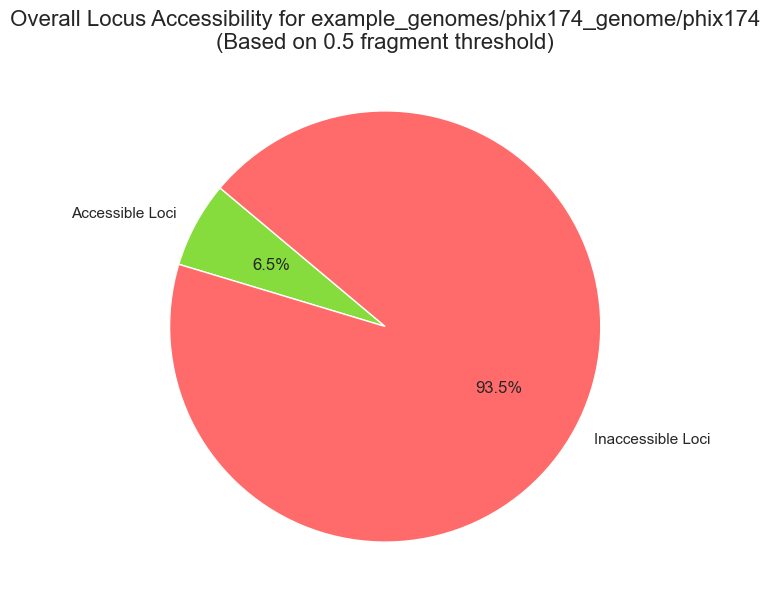

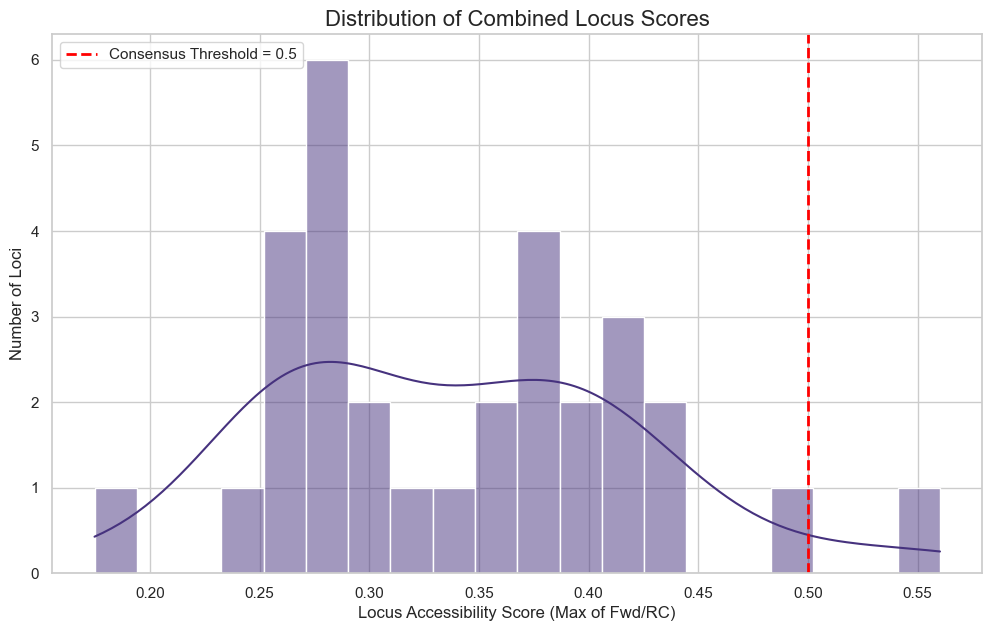

In [22]:
# Cell 5: Locus-Level Summary

if 'results_df' in locals() and not results_df.empty:
    print(f"\n--- Generating Locus-Level Analysis Report ---")

    # --- Locus Level Summary ---
    total_loci = len(results_df)
    accessible_loci_count = results_df['is_accessible'].sum()
    p_hat_loci = accessible_loci_count / total_loci
    
    print("\n--- Locus-Level Conclusion ---")
    print(f"Based on an exhaustive analysis of {total_loci:,} loci:")
    print(f"Overall, {p_hat_loci:.2%} of genomic loci are classified as 'Accessible'.")

    plt.figure(figsize=(7, 7))
    plt.pie([accessible_loci_count, total_loci - accessible_loci_count],
            labels=['Accessible Loci', 'Inaccessible Loci'], autopct='%1.1f%%',
            colors=['#86dc3d', '#ff6b6b'], startangle=140)
    plt.title(f'Overall Locus Accessibility for {base_name}\n(Based on {CONSENSUS_THRESHOLD} fragment threshold)', fontsize=16)
    plt.show()

    # --- Histogram of Combined Locus Scores ---
    plt.figure(figsize=(12, 7))
    sns.histplot(data=results_df, x='frac_open_sites', bins=max(20, min(50, total_loci // 5)), kde=True)
    plt.axvline(x=CONSENSUS_THRESHOLD, color='r', linestyle='--', linewidth=2,
                label=f'Consensus Threshold = {CONSENSUS_THRESHOLD}')
    plt.title('Distribution of Combined Locus Scores', fontsize=16)
    plt.xlabel('Locus Accessibility Score (Max of Fwd/RC)')
    plt.ylabel('Number of Loci')
    plt.legend()
    plt.show()

else:
    print("Analysis skipped because no results were generated.")

#### **Step 6: Analysis of Extreme Loci**
To understand *why* some loci are more accessible than others, this cell finds the loci with the highest and lowest combined accessibility scores. It generates an integrated plot for each, showing the accessibility profile of both the forward and reverse complement strands, with their respective sequences displayed on dual x-axes. This directly visualizes the impact of local secondary structure.


--- Investigating Most and Least Accessible Loci (Integrated Dual-Strand Profile) ---

Profile of MOST Accessible Locus
Genomic Coordinates (0-based): 3740 - 3910
Forward Strand Score: 0.1205
Reverse Complement Score: 0.5602



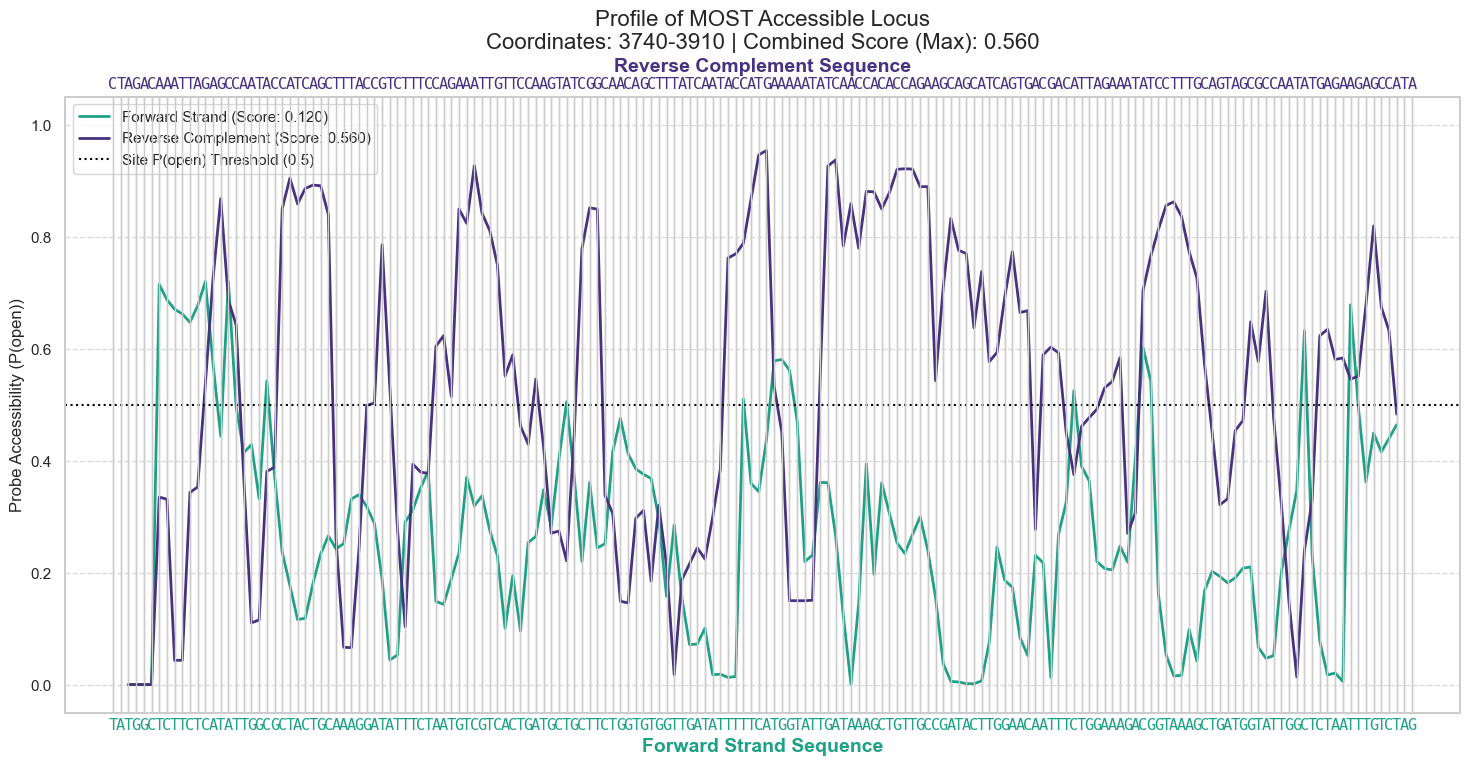


Profile of LEAST Accessible Locus
Genomic Coordinates (0-based): 4760 - 4930
Forward Strand Score: 0.1687
Reverse Complement Score: 0.1747



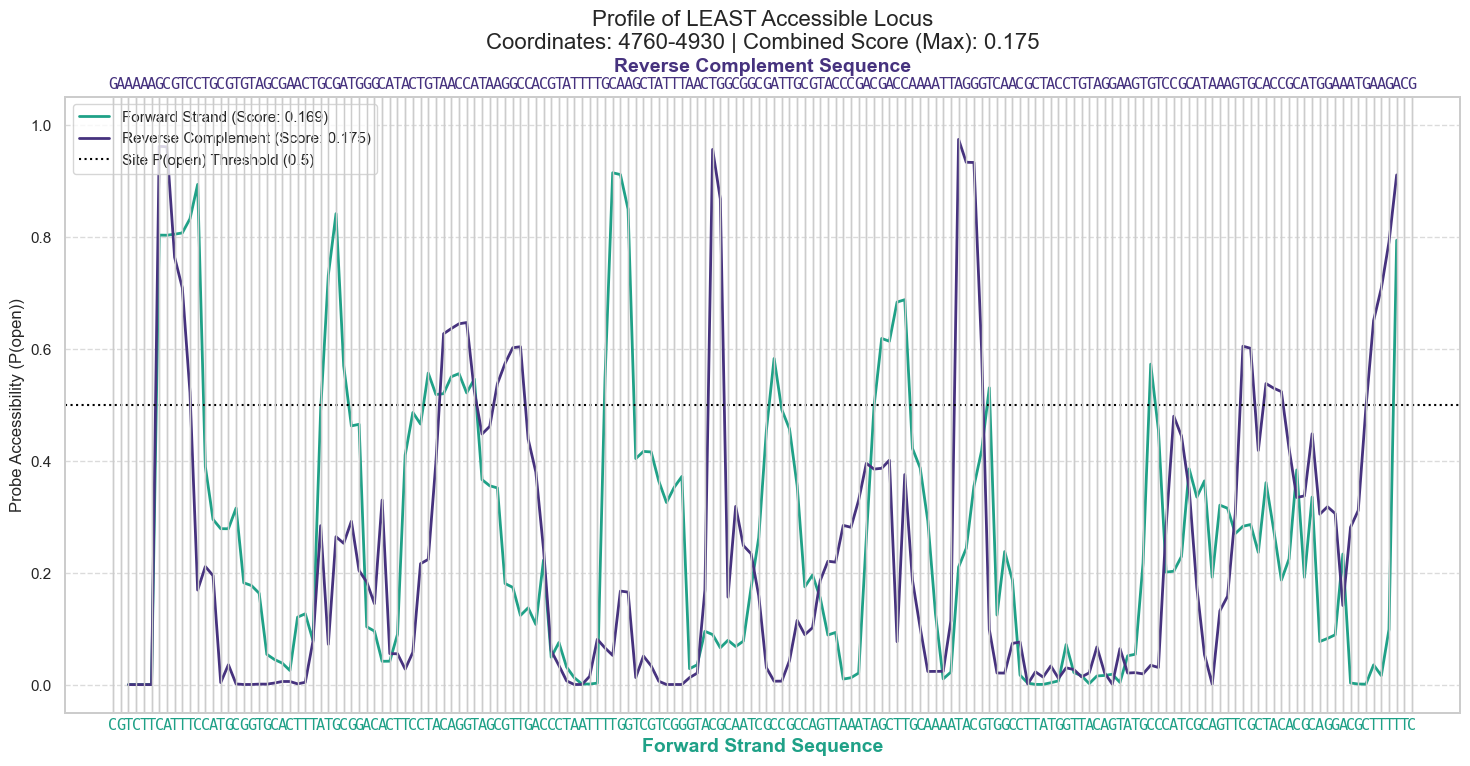

In [23]:
# Cell 6: Integrated Dual-Strand Profile for Extreme Loci

if 'results_df' in locals() and not results_df.empty:
    print(f"\n--- Investigating Most and Least Accessible Loci (Integrated Dual-Strand Profile) ---")

    def _plot_integrated_dual_strand_profile(locus_data: pd.Series):
        start_pos, end_pos = int(locus_data['start_pos']), int(locus_data['start_pos']) + len(locus_data['fwd_seq'])
        fwd_seq, rc_seq = locus_data['fwd_seq'], locus_data['rc_seq']
        fwd_score, rc_score = locus_data['frac_open_sites_fwd'], locus_data['frac_open_sites_rc']
        p_open_fwd, p_open_rc = locus_data['p_open_fwd'], locus_data['p_open_rc']
        title_prefix = locus_data['title_prefix']
        
        print("\n" + "="*80)
        print(f"{title_prefix}")
        print(f"Genomic Coordinates (0-based): {start_pos} - {end_pos}")
        print(f"Forward Strand Score: {fwd_score:.4f}")
        print(f"Reverse Complement Score: {rc_score:.4f}")
        print("="*80 + "\n")
        
        N = len(fwd_seq)
        positions = np.arange(N)
        valid_probe_pos = positions[:len(p_open_fwd)] + (PROBE_LENGTH - 1) / 2
        
        fig, ax = plt.subplots(figsize=(18, 8))
        
        fwd_color, rc_color = 'C3', 'C0'

        ax.plot(valid_probe_pos, p_open_fwd, color=fwd_color, linewidth=2, label=f'Forward Strand (Score: {fwd_score:.3f})')
        ax.plot(valid_probe_pos, p_open_rc, color=rc_color, linewidth=2, label=f'Reverse Complement (Score: {rc_score:.3f})')
        ax.axhline(y=P_OPEN_THRESHOLD, color='black', linestyle=':', linewidth=1.5, label=f'Site P(open) Threshold ({P_OPEN_THRESHOLD})')

        ax.set_xticks(positions)
        ax.set_xticklabels(list(fwd_seq), fontfamily='monospace', rotation=0, ha='center')
        ax.set_xlabel('Forward Strand Sequence', color=fwd_color, fontsize=14, fontweight='bold')
        ax.tick_params(axis='x', labelcolor=fwd_color, length=0)
        
        ax.set_ylabel('Probe Accessibility (P(open))', fontsize=12)
        ax.set_ylim(-0.05, 1.05)
        ax.grid(True, axis='y', linestyle='--', alpha=0.7)
        ax.legend(loc='upper left')

        ax_top = ax.twiny()
        ax_top.set_xlim(ax.get_xlim())
        ax_top.set_xticks(positions)
        ax_top.set_xticklabels(list(rc_seq), fontfamily='monospace', rotation=0, ha='center')
        ax_top.set_xlabel('Reverse Complement Sequence', color=rc_color, fontsize=14, fontweight='bold')
        ax_top.tick_params(axis='x', labelcolor=rc_color, length=0)

        ax.set_title(
            f"{title_prefix}\nCoordinates: {start_pos}-{end_pos} | Combined Score (Max): {max(fwd_score, rc_score):.3f}", 
            fontsize=16
        )
        plt.show()

    # Find and Plot Loci
    most_accessible_row = results_df.loc[results_df['frac_open_sites'].idxmax()].copy()
    most_accessible_row['title_prefix'] = "Profile of MOST Accessible Locus"
    _plot_integrated_dual_strand_profile(most_accessible_row)

    least_accessible_row = results_df.loc[results_df['frac_open_sites'].idxmin()].copy()
    least_accessible_row['title_prefix'] = "Profile of LEAST Accessible Locus"
    _plot_integrated_dual_strand_profile(least_accessible_row)

else:
    print("Could not analyze extreme fragments because no results were generated.")

#### **Step 7: Genome-Wide Locus Accessibility Track**
This plot provides a "bird's-eye view" of accessibility across the entire genome at the fragment level. The x-axis represents the genomic coordinates, and the lines show the accessibility score for the forward and reverse complement strands of each 170bp locus. Regions where both lines are below the red dashed threshold are highlighted, indicating they are inaccessible on both strands.


--- Generating Genome-Wide Locus Accessibility Track ---


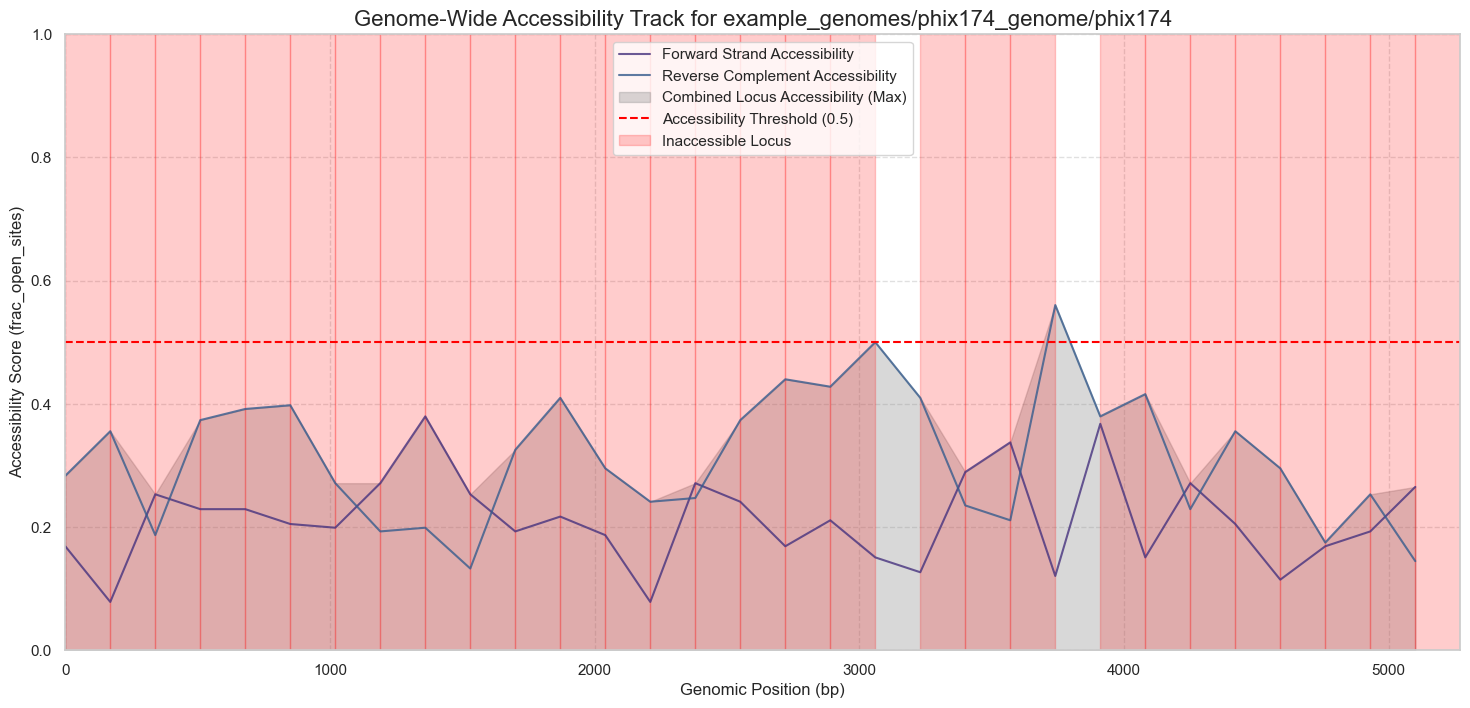

In [24]:
# Cell 7: Genome-Wide Locus Accessibility Track

if 'results_df' in locals() and not results_df.empty:
    print(f"\n--- Generating Genome-Wide Locus Accessibility Track ---")
    
    inaccessible_loci = results_df[
        (results_df['frac_open_sites_fwd'] < CONSENSUS_THRESHOLD) & 
        (results_df['frac_open_sites_rc'] < CONSENSUS_THRESHOLD)
    ]
    
    plt.figure(figsize=(18, 8))
    
    plt.plot(results_df['start_pos'], results_df['frac_open_sites_fwd'], label='Forward Strand Accessibility', color='C0', alpha=0.8, linewidth=1.5)
    plt.plot(results_df['start_pos'], results_df['frac_open_sites_rc'], label='Reverse Complement Accessibility', color='C1', alpha=0.8, linewidth=1.5)
    plt.fill_between(results_df['start_pos'], results_df['frac_open_sites'], color='grey', alpha=0.3, label='Combined Locus Accessibility (Max)')
    plt.axhline(y=CONSENSUS_THRESHOLD, color='red', linestyle='--', linewidth=1.5, label=f'Accessibility Threshold ({CONSENSUS_THRESHOLD})')
                
    if not inaccessible_loci.empty:
        legend_added = False
        for index, row in inaccessible_loci.iterrows():
            start, end = row['start_pos'], row['start_pos'] + FRAGMENT_LENGTH
            plt.axvspan(start, end, color='red', alpha=0.2, label='Inaccessible Locus' if not legend_added else "")
            legend_added = True
                     
    plt.title(f'Genome-Wide Accessibility Track for {base_name}', fontsize=16)
    plt.xlabel('Genomic Position (bp)')
    plt.ylabel('Accessibility Score (frac_open_sites)')
    plt.xlim(0, results_df['start_pos'].max() + FRAGMENT_LENGTH)
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

else:
    print("Could not generate advanced visualizations because no results were generated.")

### **Part 3: Per-Site Level Analysis**
Now we transition from the high-level fragment view to the most granular analysis. The unit of analysis here is the individual **5bp target site**. These plots reveal the fine-grained accessibility landscape and provide the most detailed view of the model's predictions.

#### **Step 8: Site-Level Summary & Distribution**
Instead of asking "is this fragment accessible?", we now ask "what is the accessibility of every single 5bp target site?". This cell calculates the total percentage of accessible 5bp sites across the entire genome (on both strands) and displays the distribution of their accessibility probabilities (`P(open)`).


--- Generating Site-Level Analysis Report ---

--- Site-Level Conclusion ---
Overall, 26.28% of all possible 5bp sites are estimated to be accessible.


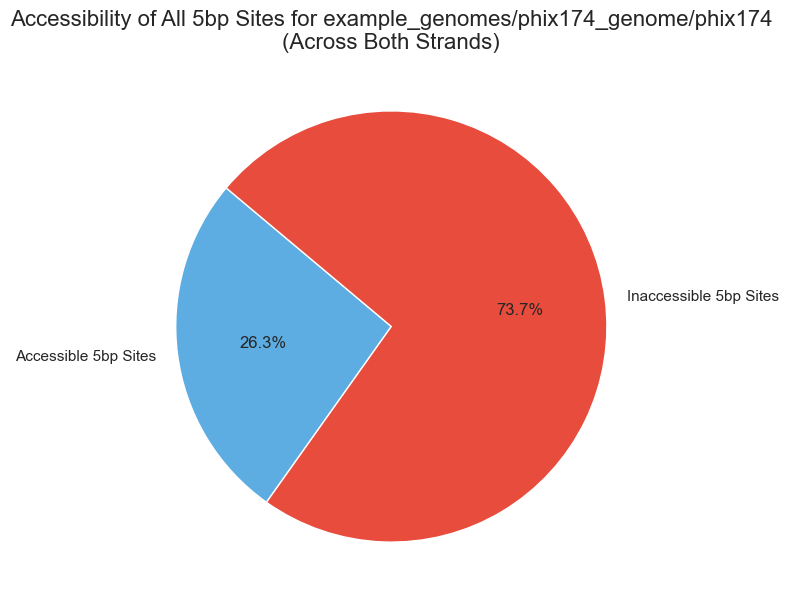


--- Generating Distribution of All Individual 5bp Site Probabilities ---


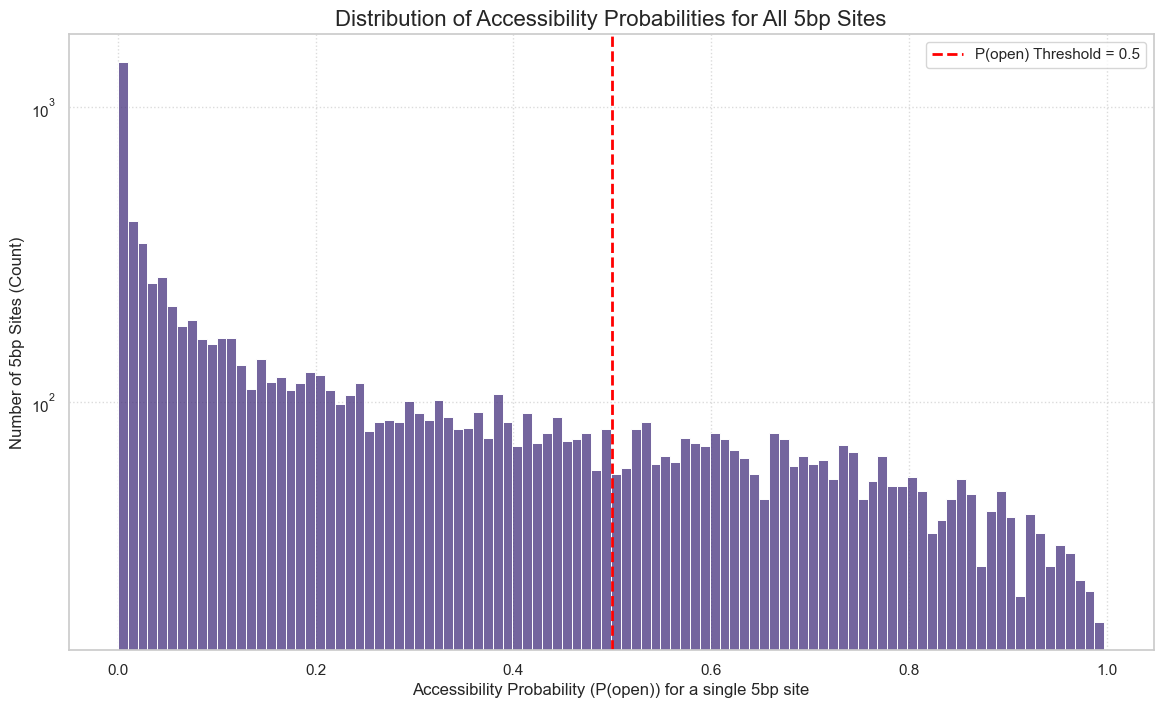


--- Quantitative Summary for All 5bp Sites ---
Total number of 5bp sites analyzed: 10,292
Mean P(open) across all sites: 0.3037
Median P(open) across all sites: 0.2185
Maximum P(open) found for any site: 0.9973


In [25]:
# Cell 8: Site-Level Summary & Distribution

if 'results_df' in locals() and not results_df.empty:
    print(f"\n--- Generating Site-Level Analysis Report ---")

    # EFFICIENT: Use pre-calculated arrays
    all_fwd_site_probs = np.concatenate(results_df['p_open_fwd'].values)
    all_rc_site_probs = np.concatenate(results_df['p_open_rc'].values)
    all_site_probabilities = np.concatenate([all_fwd_site_probs, all_rc_site_probs])
    
    # --- Site Level Summary Pie Chart ---
    total_possible_sites = len(all_site_probabilities)
    total_open_sites = np.sum(all_site_probabilities >= P_OPEN_THRESHOLD)
    total_inaccessible_sites = total_possible_sites - total_open_sites
    p_hat_sites = total_open_sites / total_possible_sites if total_possible_sites > 0 else 0

    print("\n--- Site-Level Conclusion ---")
    print(f"Overall, {p_hat_sites:.2%} of all possible 5bp sites are estimated to be accessible.")

    plt.figure(figsize=(7, 7))
    plt.pie([total_open_sites, total_inaccessible_sites],
            labels=['Accessible 5bp Sites', 'Inaccessible 5bp Sites'], autopct='%1.1f%%',
            colors=['#5dade2', '#e74c3c'], startangle=140)
    plt.title(f'Accessibility of All 5bp Sites for {base_name}\n(Across Both Strands)', fontsize=16)
    plt.show()

    # --- Distribution of All 5bp Site Probabilities ---
    print(f"\n--- Generating Distribution of All Individual 5bp Site Probabilities ---")
    plt.figure(figsize=(14, 8))
    sns.histplot(all_site_probabilities, bins=100, kde=False, stat="count")
    plt.axvline(x=P_OPEN_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'P(open) Threshold = {P_OPEN_THRESHOLD}')
    plt.title('Distribution of Accessibility Probabilities for All 5bp Sites', fontsize=16)
    plt.xlabel('Accessibility Probability (P(open)) for a single 5bp site')
    plt.ylabel('Number of 5bp Sites (Count)')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.show()
    
    print("\n--- Quantitative Summary for All 5bp Sites ---")
    print(f"Total number of 5bp sites analyzed: {len(all_site_probabilities):,}")
    print(f"Mean P(open) across all sites: {np.mean(all_site_probabilities):.4f}")
    print(f"Median P(open) across all sites: {np.median(all_site_probabilities):.4f}")
    print(f"Maximum P(open) found for any site: {np.max(all_site_probabilities):.4f}")

else:
    print("Analysis skipped because no results were generated.")

#### **Step 9: Per-Site Strand Asymmetry Analysis**
This scatter plot is a powerful visualization of structural asymmetry at the highest resolution. Each dot represents a single 5bp site. Its x-position is its accessibility on the forward strand, and its y-position is its accessibility on the reverse complement. Dots far from the diagonal red line represent sites where accessibility is highly dependent on which strand is targeted.


--- Generating High-Resolution Per-Site Correlation Plot ---


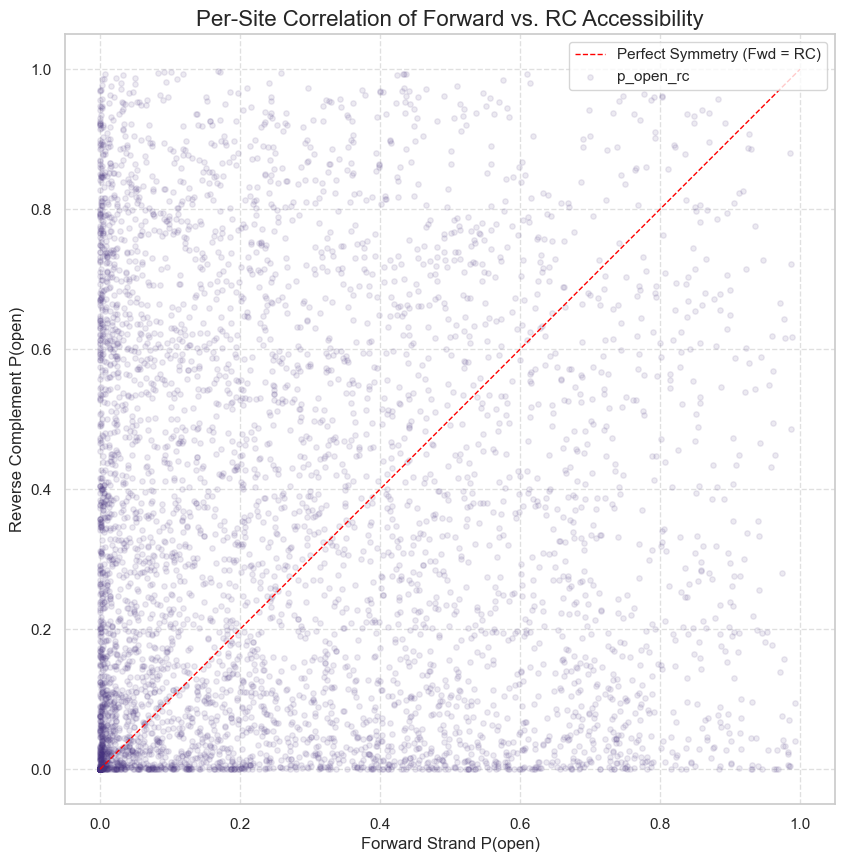

In [26]:
# Cell 9: High-Resolution Per-Site Correlation Plot

if 'results_df' in locals() and not results_df.empty:
    print(f"\n--- Generating High-Resolution Per-Site Correlation Plot ---")
    
    site_df = pd.DataFrame({'p_open_fwd': all_fwd_site_probs, 'p_open_rc': all_rc_site_probs})
    
    plt.figure(figsize=(10, 10))
    plt.plot([0, 1], [0, 1], 'r--', linewidth=1, label='Perfect Symmetry (Fwd = RC)')
    plt.scatter(data=site_df, x='p_open_fwd', y='p_open_rc', alpha=0.1, s=15)
    plt.title('Per-Site Correlation of Forward vs. RC Accessibility', fontsize=16)
    plt.xlabel('Forward Strand P(open)', fontsize=12)
    plt.ylabel('Reverse Complement P(open)', fontsize=12)
    plt.axis('square')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

else:
    print("Could not generate per-site correlation plot.")

#### **Step 10: Smoothed Per-Site Accessibility Track & Inaccessible Regions**
The raw per-site data can be noisy. By applying a moving average, we can smooth the signal to identify larger trends. This plot shows the smoothed accessibility for both strands across the entire genome. The red shaded areas highlight regions where the smoothed accessibility of **both** strands is below the site-level `P(open)` threshold, indicating robustly structured and inaccessible parts of the genome.


--- Generating Smoothed Per-Site Accessibility Track ---
Identified 6 region(s) where both strands are inaccessible based on smoothed data.


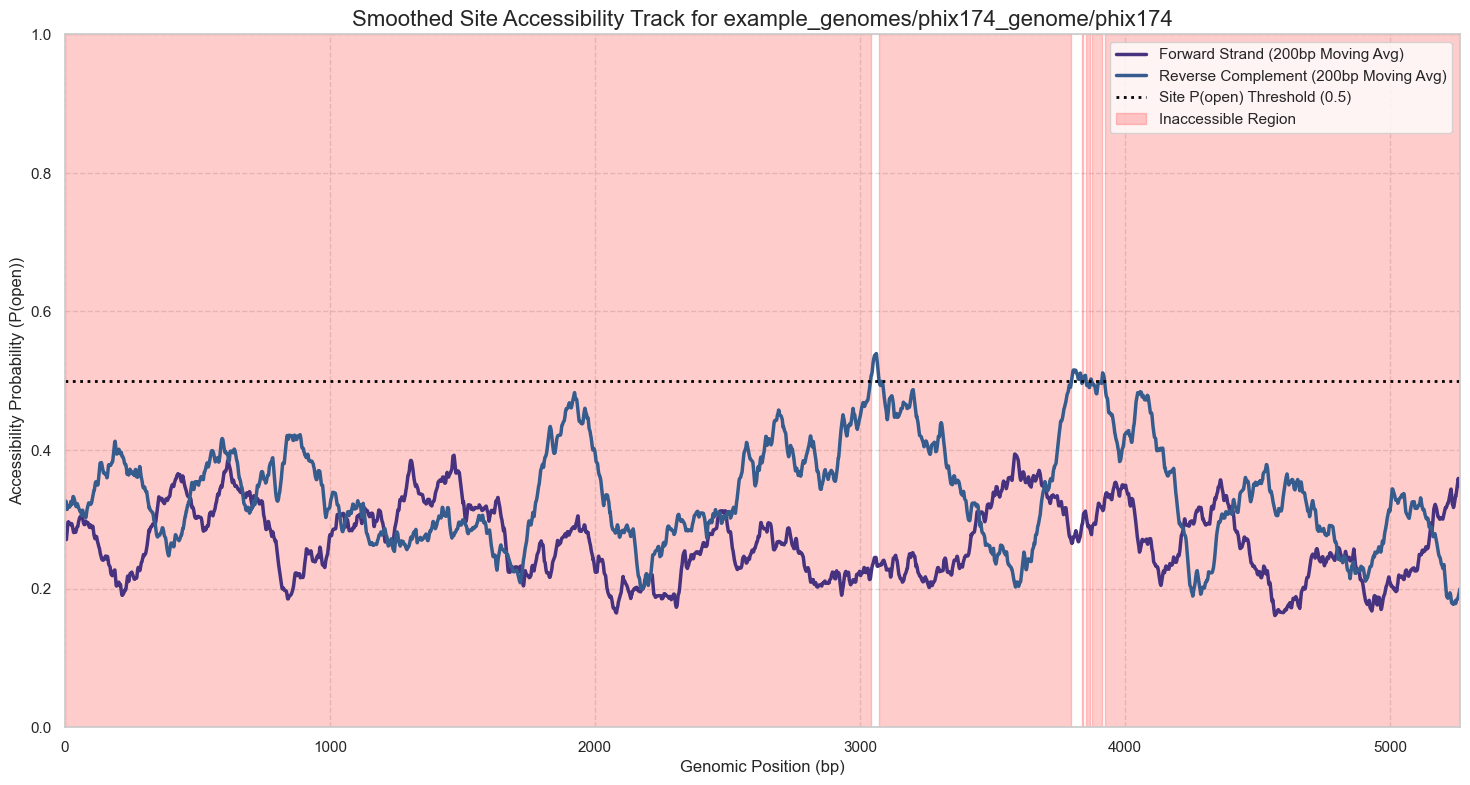

In [27]:
# Cell 10: Smoothed Track and Inaccessible Regions

if 'results_df' in locals() and not results_df.empty:
    print(f"\n--- Generating Smoothed Per-Site Accessibility Track ---")
    smoothing_window_size = 200

    # EFFICIENT: Build coordinate and probability arrays without recalculation.
    site_coords = []
    # This loop is fast as it just organizes data
    for start, arr in zip(results_df['start_pos'], results_df['p_open_fwd']):
        site_coords.extend(start + np.arange(len(arr)))
    
    fwd_df = pd.DataFrame({'coord': site_coords, 'prob': all_fwd_site_probs}).sort_values('coord')
    rc_df = pd.DataFrame({'coord': site_coords, 'prob': all_rc_site_probs}).sort_values('coord')

    fwd_df['smoothed'] = fwd_df['prob'].rolling(window=smoothing_window_size, center=True, min_periods=1).mean()
    rc_df['smoothed'] = rc_df['prob'].rolling(window=smoothing_window_size, center=True, min_periods=1).mean()
    
    # --- Identify Doubly Inaccessible Regions from Smoothed Data ---
    merged_df = pd.merge(fwd_df, rc_df, on='coord', suffixes=('_fwd', '_rc'))
    merged_df['is_inaccessible'] = (merged_df['smoothed_fwd'] < P_OPEN_THRESHOLD) & (merged_df['smoothed_rc'] < P_OPEN_THRESHOLD)
    merged_df['block'] = (merged_df['is_inaccessible'].diff().ne(0)).cumsum()
    inaccessible_blocks = merged_df[merged_df['is_inaccessible']]
    
    if not inaccessible_blocks.empty:
        inaccessible_regions = inaccessible_blocks.groupby('block')['coord'].agg(['min', 'max'])
        print(f"Identified {len(inaccessible_regions)} region(s) where both strands are inaccessible based on smoothed data.")
    else:
        inaccessible_regions = pd.DataFrame()
        print("No regions found where both strands are simultaneously inaccessible.")
    
    # --- Plotting ---
    plt.figure(figsize=(18, 9))
    plt.plot(fwd_df['coord'], fwd_df['smoothed'], label=f'Forward Strand ({smoothing_window_size}bp Moving Avg)', color='C0', linewidth=2.5)
    plt.plot(rc_df['coord'], rc_df['smoothed'], label=f'Reverse Complement ({smoothing_window_size}bp Moving Avg)', color='C1', linewidth=2.5)
    plt.axhline(y=P_OPEN_THRESHOLD, color='black', linestyle=':', linewidth=2, label=f'Site P(open) Threshold ({P_OPEN_THRESHOLD})')

    if not inaccessible_regions.empty:
        legend_added = False
        for index, region in inaccessible_regions.iterrows():
            plt.axvspan(region['min'], region['max'], color='red', alpha=0.2, label='Inaccessible Region' if not legend_added else "")
            legend_added = True
                     
    plt.title(f'Smoothed Site Accessibility Track for {base_name}', fontsize=16)
    plt.xlabel('Genomic Position (bp)')
    plt.ylabel('Accessibility Probability (P(open))')
    plt.xlim(0, fwd_df['coord'].max())
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

else:
    print("Could not generate high-resolution track.")

#### **Step 11: Global Motif Accessibility Profile (All 1024 Motifs)**
This cell addresses the core question: "What is the intrinsic accessibility of every possible 5-mer?" It generates a comprehensive, interactive bar chart showing the median accessibility of all 1024 possible 5-mer sequences. The bars are ordered from least to most accessible and color-coded by GC content.

**How to use this plot:**
* **Hover** your mouse over any bar to see the specific 5-mer sequence and its detailed statistics.
* **Click and drag** to zoom into regions of interest. Double-click to zoom back out.
* **Observe the trend:** The overall shape and color gradient reveal the powerful relationship between GC content and structural stability.


--- Analyzing Accessibility on a Per-Motif Basis ---


Aggregating motif data:   0%|          | 0/31 [00:00<?, ?it/s]



### Part A: Global Profile of All Observed Motifs ###




### Part B: Identification of Statistically Significant Problem Motifs ###
Filtering for motifs that appear at least 10 times in the genome...

--- Top 15 Most Statistically Problematic (Inaccessible) Motifs ---
Ranked by the upper bound of the 95% confidence interval for the mean P(open).


,motif,count,mean_p_open,ci_95_upper_bound
61,AATTA,13,0.0449,0.1029
887,GCTAA,11,0.0739,0.1131
815,GTTAT,18,0.0644,0.1284
42,TATTT,17,0.0780,0.1353
192,GATTT,15,0.0784,0.1358
313,GGCTT,12,0.0901,0.1423
196,TAATT,13,0.0730,0.1432
311,GTGGC,12,0.1052,0.1580
27,GTTAA,15,0.1057,0.1621
93,GTTTA,14,0.0949,0.1650




### Part C: Visualization of Extreme Reliable Motifs ###


/var/folders/v9/tqgrsgq57dbbjxxb5cd8dv5w0000gn/T/ipykernel_1394/1827310869.py:111: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




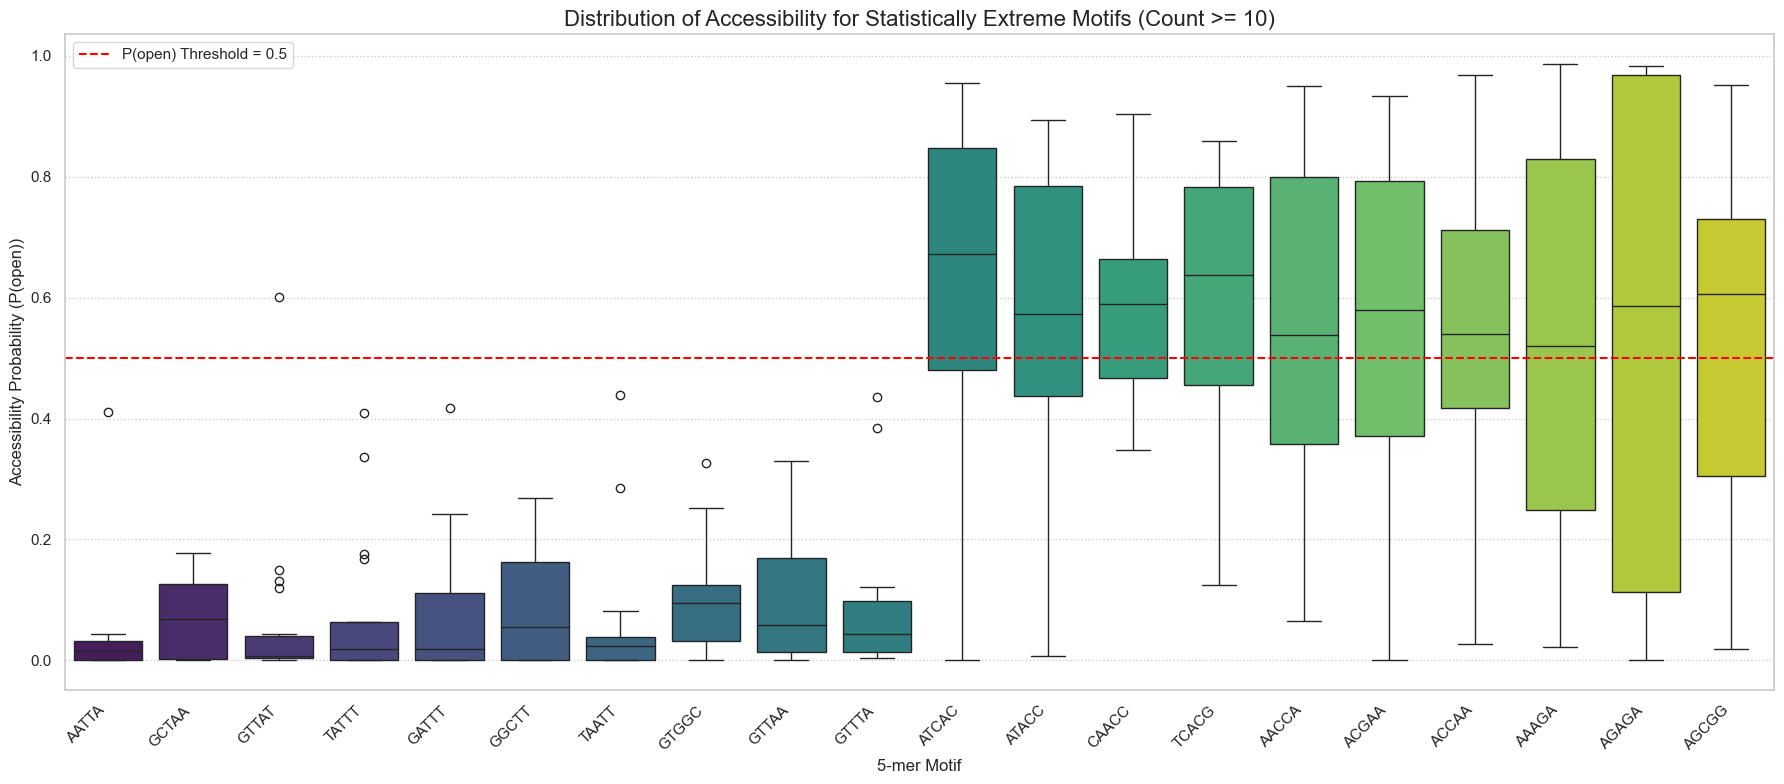

In [28]:
# Cell 11: Statistical Analysis of Per-Motif Accessibility

if 'results_df' in locals() and not results_df.empty:
    print(f"\n--- Analyzing Accessibility on a Per-Motif Basis ---")

    # --- 1. Aggregate Data by 5-mer Motif ---
    motif_data = {}
    for index, row in tqdm(results_df.iterrows(), total=len(results_df), desc="Aggregating motif data"):
        for strand_prefix in ['fwd', 'rc']:
            # --- THIS IS THE FIX: Changed column name format to match the DataFrame ---
            seq = row[f'{strand_prefix}_seq']
            # --------------------------------------------------------------------
            p_open_arr = row[f'p_open_{strand_prefix}']
            for i in range(len(p_open_arr)):
                motif = seq[i : i + PROBE_LENGTH]
                motif_data.setdefault(motif, []).append(p_open_arr[i])

    # --- 2. Calculate Comprehensive Statistics for All Motifs ---
    if not motif_data:
        print("No motif data was aggregated. Skipping analysis.")
    else:
        summary_list = []
        for motif, scores in motif_data.items():
            n = len(scores)
            mean = np.mean(scores)
            std = np.std(scores)
            sem = std / np.sqrt(n) if n > 0 else 0
            # 95% CI is approx. mean +/- 1.96 * SEM
            ci_95 = 1.96 * sem
            
            summary_list.append({
                'motif': motif,
                'gc_content': calculate_gc_content(motif),
                'count': n,
                'mean_p_open': mean,
                'median_p_open': np.median(scores),
                'std_p_open': std,
                'ci_95_upper_bound': mean + ci_95
            })
        motif_summary_df = pd.DataFrame(summary_list)

        # =================================================================
        # Part A: Global Profile of ALL Observed Motifs
        # =================================================================
        print("\n\n" + "="*80)
        print("### Part A: Global Profile of All Observed Motifs ###")
        print("="*80)
        try:
            import plotly.express as px
            plot_df_global = motif_summary_df.sort_values('median_p_open', ascending=True)
            fig = px.bar(
                plot_df_global, x='motif', y='median_p_open', color='gc_content',
                color_continuous_scale=px.colors.sequential.Viridis,
                labels={'motif': '5-mer Motif', 'median_p_open': 'Median P(open)', 'gc_content': 'GC Content (%)'},
                hover_data=['count', 'mean_p_open'],
                title=f'Global Accessibility Profile of All Observed 5-mer Motifs in {base_name}'
            )
            fig.update_layout(xaxis_title="5-mer Motifs (Ordered by Median Accessibility)", yaxis_title="Median Accessibility (P(open))", xaxis_showticklabels=False, xaxis_ticks="")
            fig.add_hline(y=P_OPEN_THRESHOLD, line_dash="dash", line_color="red", annotation_text=f"P(open) Threshold ({P_OPEN_THRESHOLD})", annotation_position="bottom right")
            fig.show()
        except ImportError:
            print("\nPlotly is not installed. Skipping interactive global plot. Please run '!pip install plotly nbformat' to enable.")

        # =================================================================
        # Part B: Identification of Statistically Significant Problem Motifs
        # =================================================================
        print("\n\n" + "="*80)
        print("### Part B: Identification of Statistically Significant Problem Motifs ###")
        print("="*80)

        MIN_COUNT_THRESHOLD = 10
        print(f"Filtering for motifs that appear at least {MIN_COUNT_THRESHOLD} times in the genome...")
        reliable_motifs_df = motif_summary_df[motif_summary_df['count'] >= MIN_COUNT_THRESHOLD].copy()

        if reliable_motifs_df.empty:
            print(f"No motifs met the reliability threshold of {MIN_COUNT_THRESHOLD} occurrences. Skipping this analysis.")
        else:
            # Sort by the 95% CI upper bound to find the most reliably INACCESSIBLE motifs
            problem_motifs_df = reliable_motifs_df.sort_values('ci_95_upper_bound', ascending=True)
            
            print(f"\n--- Top 15 Most Statistically Problematic (Inaccessible) Motifs ---")
            print("Ranked by the upper bound of the 95% confidence interval for the mean P(open).")
            display(problem_motifs_df.head(15)[['motif', 'count', 'mean_p_open', 'ci_95_upper_bound']].style.format({
                'mean_p_open': '{:.4f}',
                'ci_95_upper_bound': '{:.4f}'
            }))

            # =================================================================
            # Part C: Visualization of Reliable Extreme Motifs
            # =================================================================
            print("\n\n" + "="*80)
            print("### Part C: Visualization of Extreme Reliable Motifs ###")
            print("="*80)

            # Get the best motifs by sorting the other way (by mean, for simplicity)
            best_motifs_df = reliable_motifs_df.sort_values('mean_p_open', ascending=False)
            
            top_10_reliable = best_motifs_df.head(10)['motif'].tolist()
            # Use our new statistically-ranked list for the worst motifs
            bottom_10_reliable = problem_motifs_df.head(10)['motif'].tolist()
            
            plot_data_reliable = []
            for motif in top_10_reliable + bottom_10_reliable:
                for score in motif_data[motif]:
                    plot_data_reliable.append({'motif': motif, 'p_open': score})
            plot_df_reliable = pd.DataFrame(plot_data_reliable)
            
            plot_order_reliable = bottom_10_reliable + top_10_reliable
            
            plt.figure(figsize=(18, 8))
            sns.boxplot(data=plot_df_reliable, x='motif', y='p_open', order=plot_order_reliable, palette='viridis')
            plt.title(f'Distribution of Accessibility for Statistically Extreme Motifs (Count >= {MIN_COUNT_THRESHOLD})', fontsize=16)
            plt.ylabel('Accessibility Probability (P(open))')
            plt.xlabel('5-mer Motif')
            plt.xticks(rotation=45, ha='right')
            plt.axhline(y=P_OPEN_THRESHOLD, color='red', linestyle='--', label=f'P(open) Threshold = {P_OPEN_THRESHOLD}')
            plt.legend()
            plt.grid(True, axis='y', linestyle=':')
            plt.tight_layout()
            plt.show()

else:
    print("Could not perform per-motif analysis because no results were generated.")

#### **Step 12: Per-Motif Accessibility Analysis**
This section directly addresses the question: "Are certain 5-mer sequences intrinsically harder to access than others?" It aggregates all per-site accessibility scores by the 5-mer sequence (motif) of the target. The summary tables identify the most and least accessible motifs on average, while the box plot visualizes the full distribution of their accessibility scores across the genome. This is highly valuable for identifying potentially problematic probe sequences.


--- Analyzing Accessibility on a Per-Motif Basis ---


Aggregating motif data:   0%|          | 0/31 [00:00<?, ?it/s]



### Part A: Global Profile of All Observed Motifs ###




### Part B: Identification of Statistically Significant Problem Motifs ###
Filtering for motifs that appear at least 10 times in the genome...

--- Top 15 Most Statistically Problematic (Inaccessible) Motifs ---
Ranked by the upper bound of the 95% confidence interval for the mean P(open).


,motif,count,mean_p_open,ci_95_upper_bound
61,AATTA,13,0.0449,0.1029
887,GCTAA,11,0.0739,0.1131
815,GTTAT,18,0.0644,0.1284
42,TATTT,17,0.0780,0.1353
192,GATTT,15,0.0784,0.1358
313,GGCTT,12,0.0901,0.1423
196,TAATT,13,0.0730,0.1432
311,GTGGC,12,0.1052,0.1580
27,GTTAA,15,0.1057,0.1621
93,GTTTA,14,0.0949,0.1650




### Part C: Visualization of Extreme Reliable Motifs ###


/var/folders/v9/tqgrsgq57dbbjxxb5cd8dv5w0000gn/T/ipykernel_1394/4141620663.py:106: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




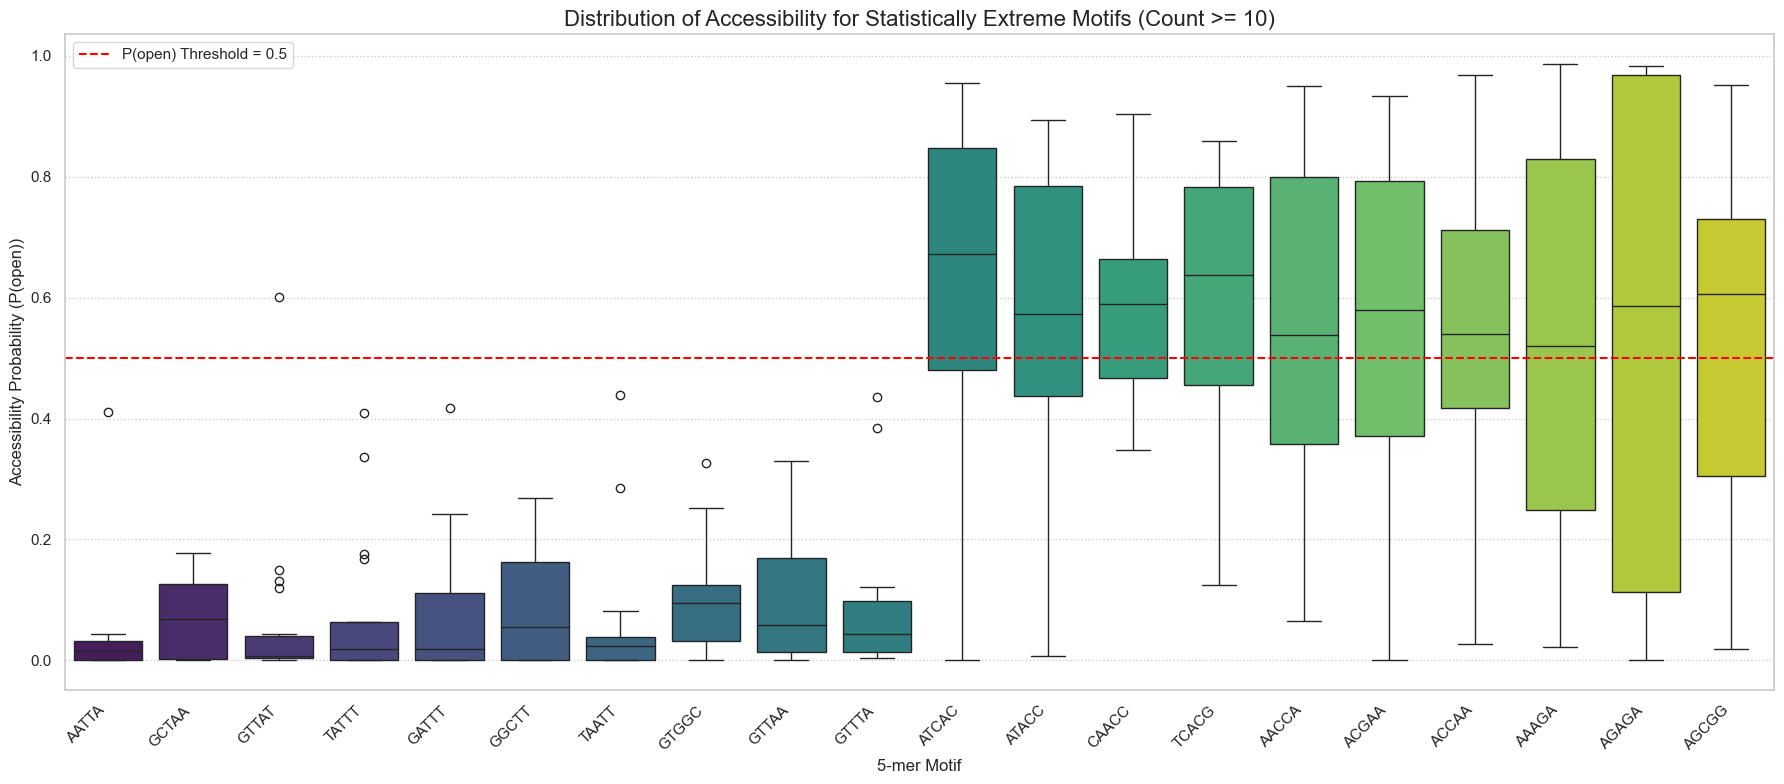

In [29]:
# Cell 12: Statistical Analysis of Per-Motif Accessibility

if 'results_df' in locals() and not results_df.empty:
    print(f"\n--- Analyzing Accessibility on a Per-Motif Basis ---")

    # --- 1. Aggregate Data by 5-mer Motif ---
    motif_data = {}
    for index, row in tqdm(results_df.iterrows(), total=len(results_df), desc="Aggregating motif data"):
        for strand_prefix in ['fwd', 'rc']:
            seq = row[f'{strand_prefix}_seq']
            p_open_arr = row[f'p_open_{strand_prefix}']
            for i in range(len(p_open_arr)):
                motif = seq[i : i + PROBE_LENGTH]
                motif_data.setdefault(motif, []).append(p_open_arr[i])

    # --- 2. Calculate Comprehensive Statistics for All Motifs ---
    if not motif_data:
        print("No motif data was aggregated. Skipping analysis.")
    else:
        summary_list = []
        for motif, scores in motif_data.items():
            n = len(scores)
            mean = np.mean(scores)
            std = np.std(scores)
            sem = std / np.sqrt(n) if n > 0 else 0
            ci_95 = 1.96 * sem
            
            summary_list.append({
                'motif': motif,
                # --- THIS IS THE FIX: Added gc_content calculation here ---
                'gc_content': calculate_gc_content(motif),
                # ---------------------------------------------------------
                'count': n,
                'mean_p_open': mean,
                'median_p_open': np.median(scores),
                'std_p_open': std,
                'ci_95_upper_bound': mean + ci_95
            })
        motif_summary_df = pd.DataFrame(summary_list)

        # =================================================================
        # Part A: Global Profile of ALL Observed Motifs
        # =================================================================
        print("\n\n" + "="*80)
        print("### Part A: Global Profile of All Observed Motifs ###")
        print("="*80)
        try:
            import plotly.express as px
            plot_df_global = motif_summary_df.sort_values('median_p_open', ascending=True)
            fig = px.bar(
                plot_df_global, x='motif', y='median_p_open', color='gc_content',
                color_continuous_scale=px.colors.sequential.Viridis,
                labels={'motif': '5-mer Motif', 'median_p_open': 'Median P(open)', 'gc_content': 'GC Content (%)'},
                hover_data=['count', 'mean_p_open'],
                title=f'Global Accessibility Profile of All Observed 5-mer Motifs in {base_name}'
            )
            fig.update_layout(xaxis_title="5-mer Motifs (Ordered by Median Accessibility)", yaxis_title="Median Accessibility (P(open))", xaxis_showticklabels=False, xaxis_ticks="")
            fig.add_hline(y=P_OPEN_THRESHOLD, line_dash="dash", line_color="red", annotation_text=f"P(open) Threshold ({P_OPEN_THRESHOLD})", annotation_position="bottom right")
            fig.show()
        except ImportError:
            print("\nPlotly is not installed. Skipping interactive global plot. Please run '!pip install plotly nbformat' to enable.")

        # =================================================================
        # Part B: Identification of Statistically Significant Problem Motifs
        # =================================================================
        print("\n\n" + "="*80)
        print("### Part B: Identification of Statistically Significant Problem Motifs ###")
        print("="*80)

        MIN_COUNT_THRESHOLD = 10
        print(f"Filtering for motifs that appear at least {MIN_COUNT_THRESHOLD} times in the genome...")
        reliable_motifs_df = motif_summary_df[motif_summary_df['count'] >= MIN_COUNT_THRESHOLD].copy()

        if reliable_motifs_df.empty:
            print(f"No motifs met the reliability threshold of {MIN_COUNT_THRESHOLD} occurrences. Skipping this analysis.")
        else:
            problem_motifs_df = reliable_motifs_df.sort_values('ci_95_upper_bound', ascending=True)
            
            print(f"\n--- Top 15 Most Statistically Problematic (Inaccessible) Motifs ---")
            print("Ranked by the upper bound of the 95% confidence interval for the mean P(open).")
            display(problem_motifs_df.head(15)[['motif', 'count', 'mean_p_open', 'ci_95_upper_bound']].style.format({
                'mean_p_open': '{:.4f}',
                'ci_95_upper_bound': '{:.4f}'
            }))

            # =================================================================
            # Part C: Visualization of Reliable Extreme Motifs
            # =================================================================
            print("\n\n" + "="*80)
            print("### Part C: Visualization of Extreme Reliable Motifs ###")
            print("="*80)

            best_motifs_df = reliable_motifs_df.sort_values('mean_p_open', ascending=False)
            top_10_reliable = best_motifs_df.head(10)['motif'].tolist()
            bottom_10_reliable = problem_motifs_df.head(10)['motif'].tolist()
            
            plot_data_reliable = []
            for motif in top_10_reliable + bottom_10_reliable:
                for score in motif_data[motif]:
                    plot_data_reliable.append({'motif': motif, 'p_open': score})
            plot_df_reliable = pd.DataFrame(plot_data_reliable)
            
            plot_order_reliable = bottom_10_reliable + top_10_reliable
            
            plt.figure(figsize=(18, 8))
            sns.boxplot(data=plot_df_reliable, x='motif', y='p_open', order=plot_order_reliable, palette='viridis')
            plt.title(f'Distribution of Accessibility for Statistically Extreme Motifs (Count >= {MIN_COUNT_THRESHOLD})', fontsize=16)
            plt.ylabel('Accessibility Probability (P(open))')
            plt.xlabel('5-mer Motif')
            plt.xticks(rotation=45, ha='right')
            plt.axhline(y=P_OPEN_THRESHOLD, color='red', linestyle='--', label=f'P(open) Threshold = {P_OPEN_THRESHOLD}')
            plt.legend()
            plt.grid(True, axis='y', linestyle=':')
            plt.tight_layout()
            plt.show()

else:
    print("Could not perform per-motif analysis because no results were generated.")

#### **Step 13: Summary Statistics and Deeper Insights**
This final analysis cell synthesizes the results to provide high-level insights. It calculates the overall genome GC content, breaks down accessibility by GC content bin, and, most importantly, analyzes accessibility as a function of the specific experimental condition (effective temperature) applied. This helps identify which conditions and sequence types are most challenging for probe binding.


--- Analyzing Accessibility vs. 5-mer Motif GC Content ---

Average accessibility for motifs of a given GC content:


,gc_content_label,avg_median_accessibility
0,0%,0.045
1,20%,0.209
2,40%,0.239
3,60%,0.283
4,80%,0.370
5,100%,0.393


/var/folders/v9/tqgrsgq57dbbjxxb5cd8dv5w0000gn/T/ipykernel_1394/2601431820.py:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




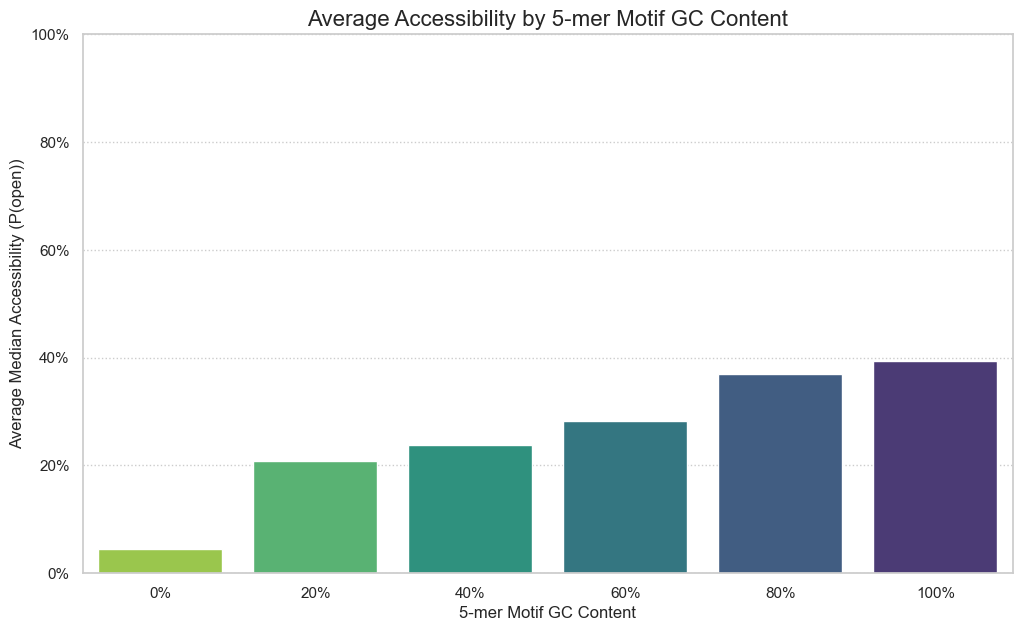

In [30]:
# Cell 13: Accessibility vs. 5-mer Motif GC Content

if 'motif_summary_df' in locals() and not motif_summary_df.empty:
    print(f"\n--- Analyzing Accessibility vs. 5-mer Motif GC Content ---")

    # --- 1. Group motifs by their own GC content ---
    # We take the mean of the median_p_open scores for all motifs within a GC class.
    # This gives the "typical" accessibility for a motif of that composition.
    motif_gc_summary = motif_summary_df.groupby('gc_content')['median_p_open'].mean().reset_index()
    motif_gc_summary.rename(columns={'median_p_open': 'avg_median_accessibility'}, inplace=True)
    
    # Format the GC content column for better plotting labels
    motif_gc_summary['gc_content_label'] = motif_gc_summary['gc_content'].apply(lambda x: f'{int(x)}%')

    print("\nAverage accessibility for motifs of a given GC content:")
    display(motif_gc_summary[['gc_content_label', 'avg_median_accessibility']].style.format({'avg_median_accessibility': '{:.3f}'}))

    # --- 2. Plotting the results ---
    plt.figure(figsize=(12, 7))
    sns.barplot(
        data=motif_gc_summary,
        x='gc_content_label',
        y='avg_median_accessibility',
        palette='viridis_r' # Reversed viridis: yellow for low GC, purple for high GC
    )
    
    plt.title('Average Accessibility by 5-mer Motif GC Content', fontsize=16)
    plt.xlabel('5-mer Motif GC Content')
    plt.ylabel('Average Median Accessibility (P(open))')
    plt.ylim(0, 1) # Set y-axis from 0 to 1
    
    # Format y-axis ticks as percentages
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    
    plt.grid(True, axis='y', linestyle=':')
    plt.show()

else:
    print("Could not perform per-motif GC analysis because motif summary was not generated.")

### **Part 4: Reproducibility**

#### **Step 14: Save Environment**
Finally, we save the computational environment (all the specific library versions used) to a file. This is crucial for ensuring that the analysis can be reproduced by others in the future.

In [31]:
# Cell 14: Save Environment for Reproducibility
print(f"\n--- Saving Conda environment to {ENVIRONMENT_FILE} ---")
try:
    import subprocess
    with open(ENVIRONMENT_FILE, "w") as f:
        subprocess.run(["conda", "env", "export"], stdout=f, shell=True)
    print(f"Environment saved successfully.")
except Exception as e:
    print(f"Could not save environment automatically. Error: {e}")
    print("To save manually, run this command in your terminal: conda env export > environment.yml")


--- Saving Conda environment to environment.yml ---
Environment saved successfully.
